In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import yfinance as yf
import math
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
from dateutil.parser import parse 
import matplotlib as mpl
import seaborn as sns
import statsmodels

In [2]:
df=yf.download('TCS.NS',start='2021-01-01',end='2023-01-01')
df=df['Close']
df

[*********************100%***********************]  1 of 1 completed


Date
2021-01-01    2928.250000
2021-01-04    3039.449951
2021-01-05    3093.000000
2021-01-06    3051.500000
2021-01-07    3032.800049
                 ...     
2022-12-26    3252.899902
2022-12-27    3259.500000
2022-12-28    3257.100098
2022-12-29    3268.750000
2022-12-30    3256.699951
Name: Close, Length: 496, dtype: float64

<AxesSubplot:xlabel='Date'>

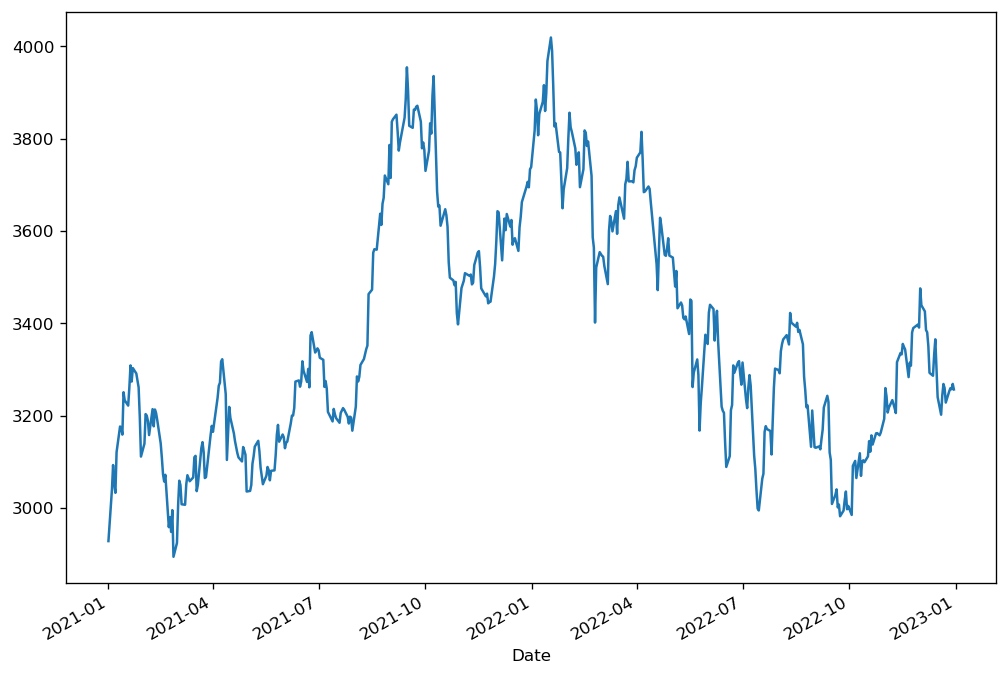

In [3]:
df.plot()

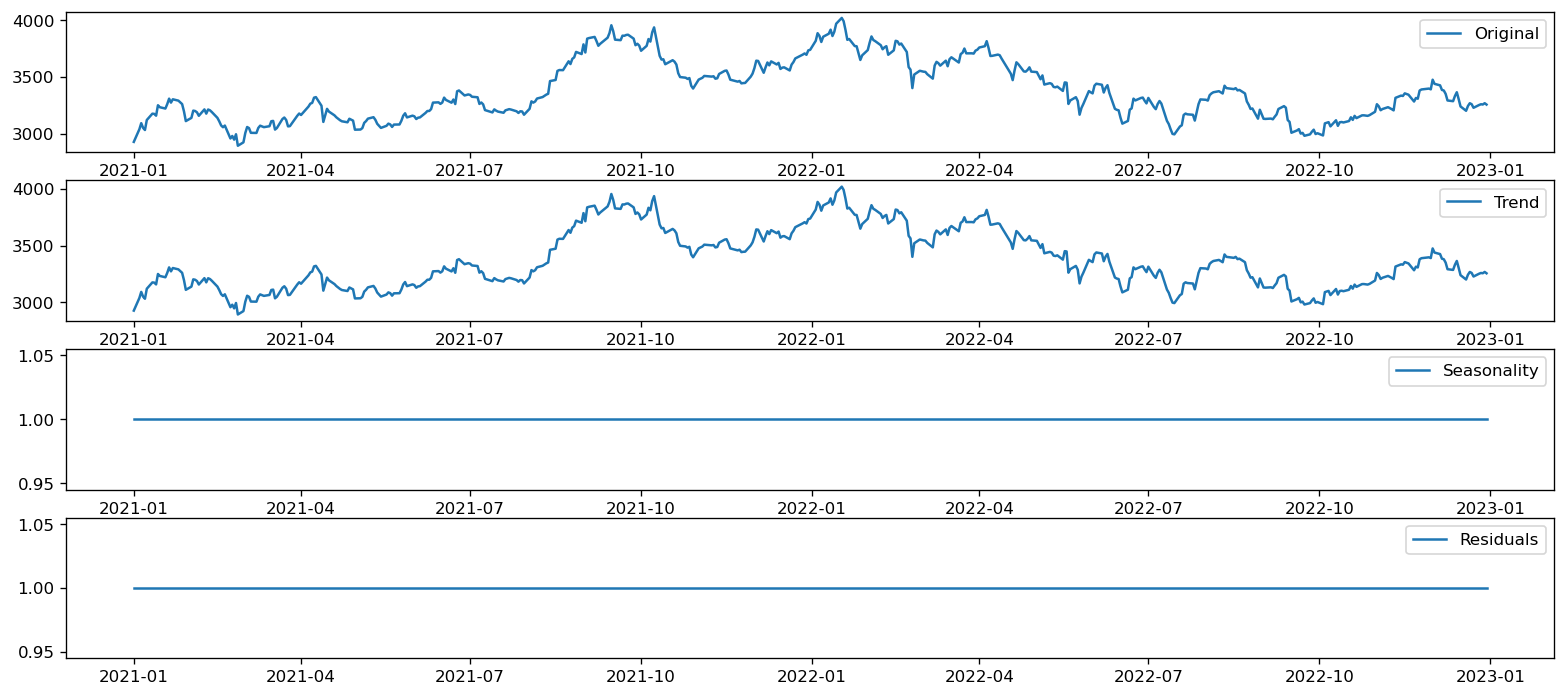

In [4]:
#Decomposition of time series into its components:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df,period=1,model = 'multiplicative')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,7))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

In [7]:
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(df,trend='mul')
model_fit = model.fit()
print(model_fit.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  496
Model:             ExponentialSmoothing   SSE                        1148161.548
Optimized:                         True   AIC                           3850.560
Trend:                   Multiplicative   BIC                           3867.386
Seasonal:                          None   AICC                          3850.732
Seasonal Periods:                  None   Date:                 Sun, 28 May 2023
Box-Cox:                          False   Time:                         11:01:35
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
smoothing_trend            0.02369

In [8]:
#Splitting training and testing data
tr=int(len(df)*0.8)
train=df[0:tr]
test=df[tr:]
print(train.shape,test.shape)

(396,) (100,)


In [10]:
hw_tr=ExponentialSmoothing(train,trend='mul')
model_train=hw_tr.fit()
print(model_train.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  396
Model:             ExponentialSmoothing   SSE                         984088.635
Optimized:                         True   AIC                           3103.951
Trend:                   Multiplicative   BIC                           3119.876
Seasonal:                          None   AICC                          3104.167
Seasonal Periods:                  None   Date:                 Sun, 28 May 2023
Box-Cox:                          False   Time:                         11:01:56
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9946748                alpha                 True
smoothing_trend            0.03433

In [11]:
#Prediction based on test data
start=len(train)
end=len(train)+len(test)-1
test_pred=model_train.predict(start=start,end=end).rename('Prediction on test data')
test_pred.index=df.index[start:end+1]
print(test_pred)

Date
2022-08-05    3358.287225
2022-08-08    3361.695813
2022-08-10    3365.107860
2022-08-11    3368.523370
2022-08-12    3371.942346
                 ...     
2022-12-26    3698.047912
2022-12-27    3701.801348
2022-12-28    3705.558595
2022-12-29    3709.319655
2022-12-30    3713.084532
Name: Prediction on test data, Length: 100, dtype: float64


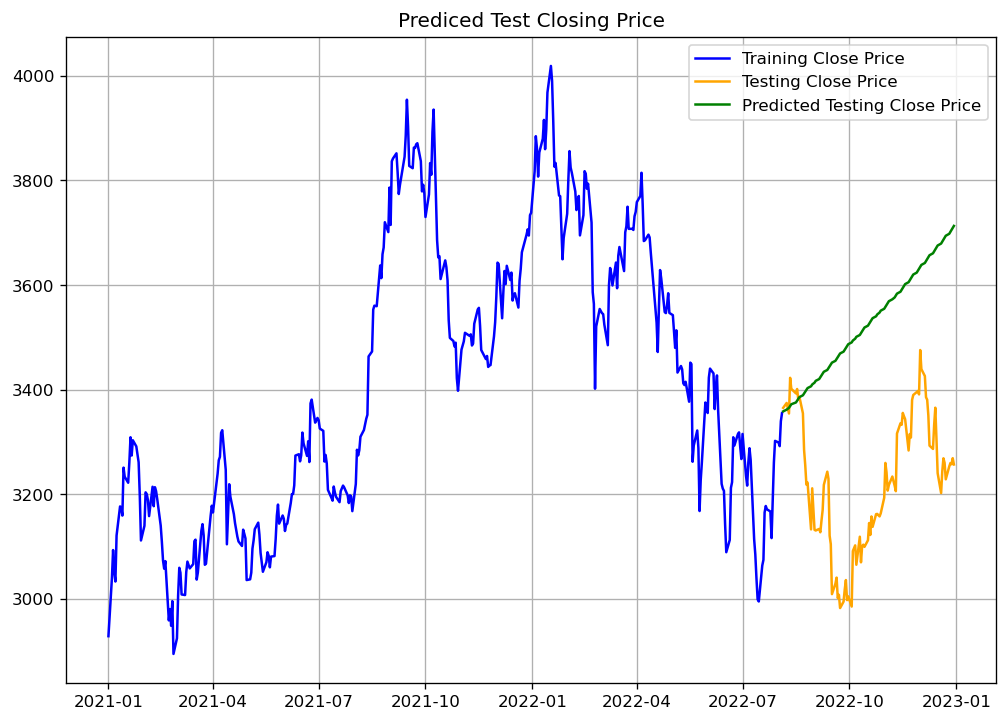

In [12]:
#Plotting actual against predicted
plt.grid(True)
plt.plot(train,color='blue',label='Training Close Price')
plt.plot(test, color = 'orange', label='Testing Close Price')
plt.plot(test_pred, color = 'green', label='Predicted Testing Close Price')
plt.title('Prediced Test Closing Price')
plt.legend()

In [13]:
#Forecasting: Predicting future data
index_future_dates=pd.date_range(start='2023-01-02',end='2023-04-11')
#print(index_future_dates)
forecast=model_train.predict(start=len(df),end=len(df)+99).rename('Holt-Winters exponential smoothing Forecast')
forecast.index=index_future_dates
print(forecast)

2023-01-02    3716.853231
2023-01-03    3720.625755
2023-01-04    3724.402108
2023-01-05    3728.182294
2023-01-06    3731.966316
                 ...     
2023-04-07    4092.890336
2023-04-08    4097.044529
2023-04-09    4101.202938
2023-04-10    4105.365569
2023-04-11    4109.532424
Freq: D, Name: Holt-Winters exponential smoothing Forecast, Length: 100, dtype: float64


Text(0.5, 1.0, 'Forecasting using Expoential Smoothing')

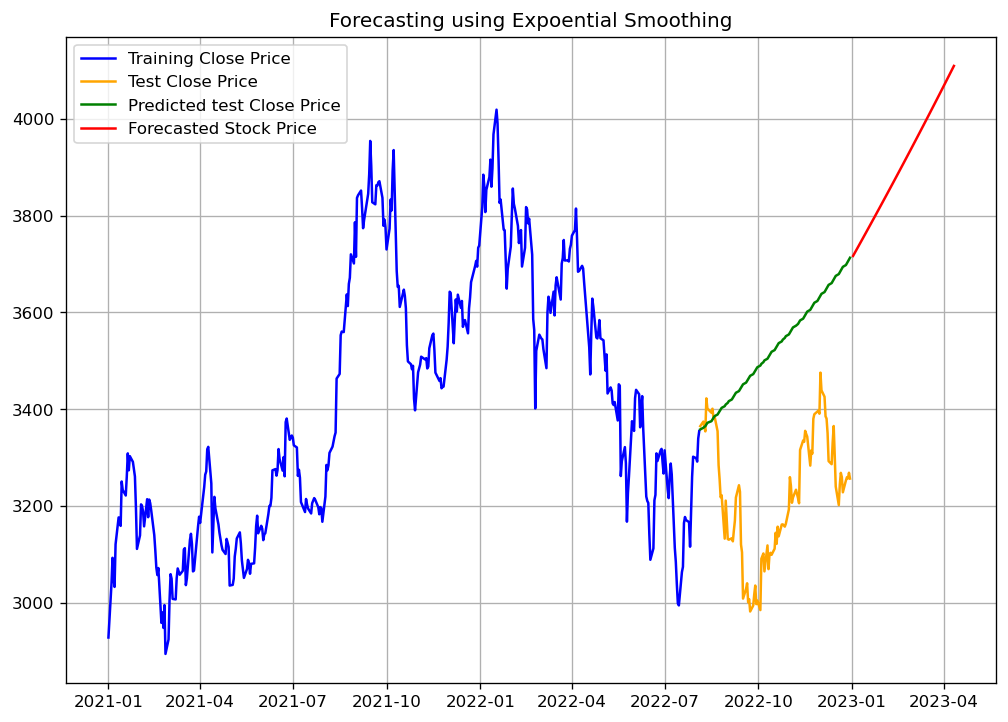

In [14]:
plt.grid(True)
plt.plot(train,color='blue',label='Training Close Price')
plt.plot(test, color = 'orange', label='Test Close Price')
plt.plot(test_pred, color = 'green', label='Predicted test Close Price')
plt.plot(forecast, color = 'red',label='Forecasted Stock Price')
plt.legend()
plt.title('Forecasting using Expoential Smoothing')

In [15]:
#Accuracy: MAPE
TRAIN=train.reset_index(drop=True)
PRED=forecast.reset_index(drop=True) 
mape = np.mean(np.abs(PRED - TRAIN)/np.abs(TRAIN))
mape

0.25226591739777776

In [16]:
from math import sqrt
rmse=sqrt(mean_squared_error(test,test_pred))
print(rmse)

337.56924403782864
